In [1]:
import warnings                                  
warnings.filterwarnings('ignore')

import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
car = pd.read_csv('Series/monthly-car-sales.csv')

In [3]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y, autolag='AIC')[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

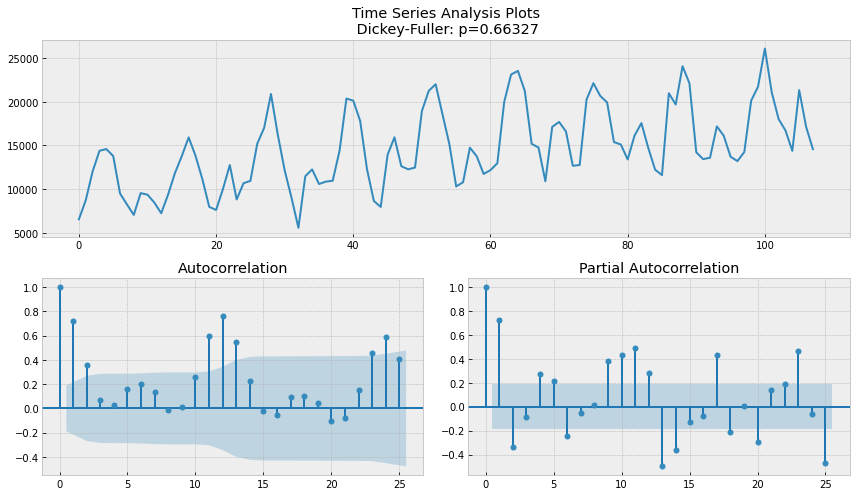

In [4]:
tsplot(car['Sales'], lags=25)

Тест Дики-Фуллера не отвергает нулевую гипотезу о наличии единичного корня.

Для этого уберем тренд и сезонность с которой мы должны разбираться до моделирования. 
Для этого возьмем «сезонную разницу», что означает простое вычитание ряда из самого себя с лагом, равным сезонному периоду.

In [5]:
series = scs.boxcox(car['Sales'], 0)
series = series[2:] - series[:-2]
series = series[12:] - series[:-12]
series

array([-1.15582460e-01, -1.14776076e-01,  1.03663026e-01,  4.55453940e-02,
        7.19079752e-02, -3.61957256e-02, -8.31528389e-02,  8.20892684e-02,
        2.32786946e-01, -6.37450810e-03,  7.95207840e-02,  1.13433543e-01,
       -1.38819930e-01,  5.51673606e-02,  2.17309563e-02, -5.11622452e-02,
       -1.85854791e-01, -3.85511222e-02, -3.98368623e-01,  1.54200973e-02,
        2.72205957e-01,  4.66810506e-02,  5.73998564e-02, -1.81037752e-01,
       -7.08986237e-02,  1.79060617e-01,  1.60827809e-02, -8.59264591e-02,
        4.78786526e-02, -1.35034244e-01,  3.47402927e-01,  2.34361897e-01,
       -9.50792137e-02, -1.74371157e-02, -1.40922817e-01, -4.80502528e-02,
        1.52269620e-01, -8.63420016e-02, -1.84299731e-01, -2.32752946e-04,
        1.23042932e-01,  1.34049589e-01,  9.14698036e-02, -1.18901898e-01,
       -4.51375904e-01, -1.30275443e-01,  1.40215641e-01,  1.12012788e-01,
        6.07802591e-02,  4.52062890e-02,  1.32746528e-02,  4.99422074e-02,
       -6.60973979e-02,  

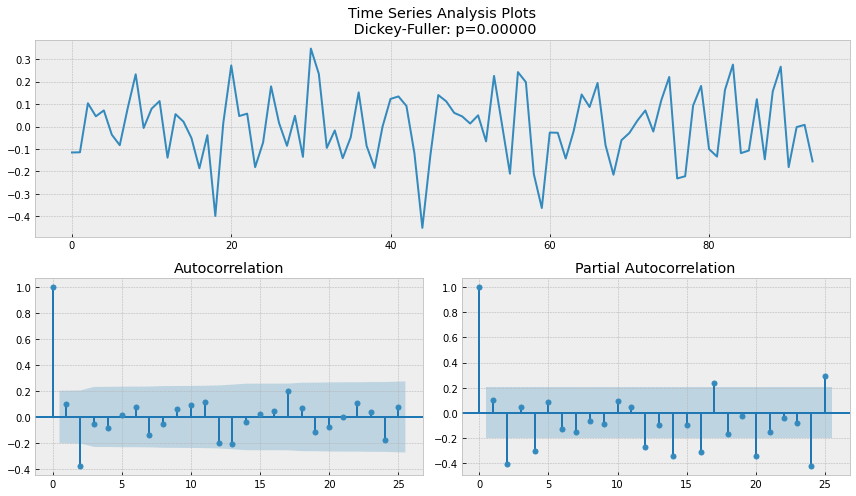

In [6]:
tsplot(series, lags=25)

На графике - у нас нет видимого тренда, поэтому среднее значение постоянно, а дисперсия в значительной степени стабильна.

### ARIMA

d - порядок сезонной дифференцирования
    d = 1
    
D - порядок сезонной интеграции (дифференцирование)
    D = 1  
    
p - номер последнего несезонного лага, при котором частичная автокорреляция значима.
    p = 4  
    
P - номер последнего сезонного лага, при котором частичная автокорреляция значима.
    P = 2

q - номер последнего несезонного лага, при котором автокорреляция значима. График ACF.  
q - не может быть больше длины сезона.  
    q = 2
    
Q - номер последнего сезонного лага, при котором автокорреляция значима.   
    Q = 1

In [7]:
# setting initial values and some bounds for them
ps = range(0, 4)
d=1 
qs = range(0, 2)
Ps = range(0, 5)
D=1 
Qs = range(0, 2)
s = 12

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)


In [8]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(car['Sales'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [9]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/80 [00:00<?, ?it/s]

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

CPU times: user 5min 5s, sys: 42.3 s, total: 5min 47s
Wall time: 1min 28s


In [10]:
result_table.head()

,parameters,aic
0,"(0, 1, 4, 0)",1682.534656
1,"(1, 1, 4, 0)",1682.928581
2,"(1, 1, 2, 1)",1683.038734
3,"(0, 1, 2, 1)",1683.105078
4,"(1, 1, 0, 1)",1683.746797


In [11]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(car['Sales'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(4, 1, [], 12)   Log Likelihood                -835.267
Date:                             Sun, 25 Jul 2021   AIC                           1682.535
Time:                                     12:57:07   BIC                           1697.858
Sample:                                          0   HQIC                          1688.726
                                             - 108                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7560      0.073    -10.314      0.000      -0.900      -0.612
ar.S.L12      -0.4130      

#### Посмотрим на остатки модели

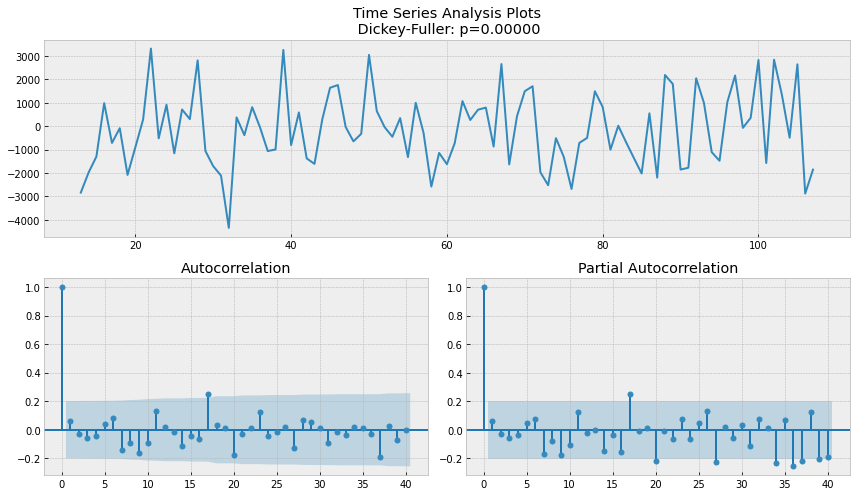

In [12]:
tsplot(best_model.resid[12+1:], lags=40)

Понятно, что невязки стационарны и явных автокорреляций нет.  
Сделаем прогнозы, используя нашу модель.

In [13]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management,  [0,+∞)

$$MAPE=100/n ∑^n i=1 ~|yi−ŷ i|~/~yi$$

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

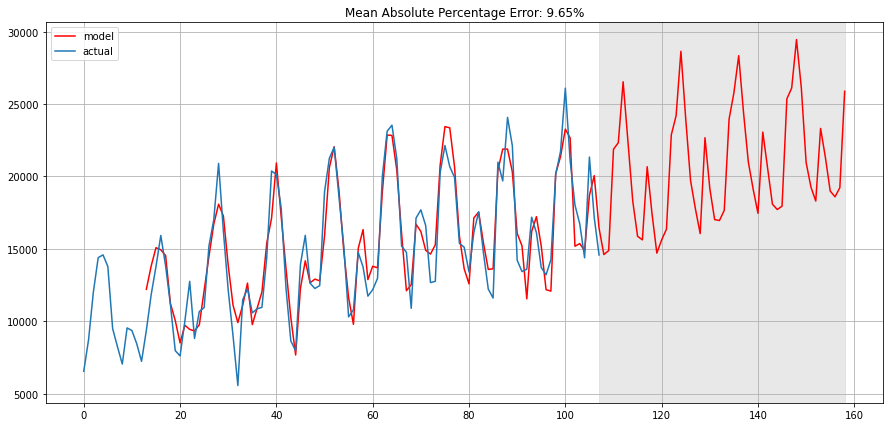

In [15]:
plotSARIMA(car[['Sales']], best_model, 50)

## Linear models on time series

In [16]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(car['Sales'].copy())
data.columns = ['y']

In [17]:
# Adding the lag of the target variable from 4 steps back up to 12
for i in range(4, 24):
    data["lag_{}".format(i)] = data.y.shift(i)

In [18]:
# take a look at the new dataframe 
data.tail(7)

,y,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,...,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23
101,21084,14251.0,13210.0,13713.0,16119.0,17187.0,13598.0,13434.0,14220.0,22114.0,...,19692.0,20985.0,11608.0,12225.0,14720.0,17562.0,16135.0,13401.0,15113.0,15388.0
102,18024,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0,13598.0,13434.0,14220.0,...,24081.0,19692.0,20985.0,11608.0,12225.0,14720.0,17562.0,16135.0,13401.0,15113.0
103,16722,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0,13598.0,13434.0,...,22114.0,24081.0,19692.0,20985.0,11608.0,12225.0,14720.0,17562.0,16135.0,13401.0
104,14385,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0,13598.0,...,14220.0,22114.0,24081.0,19692.0,20985.0,11608.0,12225.0,14720.0,17562.0,16135.0
105,21342,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0,...,13434.0,14220.0,22114.0,24081.0,19692.0,20985.0,11608.0,12225.0,14720.0,17562.0
106,17180,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,...,13598.0,13434.0,14220.0,22114.0,24081.0,19692.0,20985.0,11608.0,12225.0,14720.0
107,14577,16722.0,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,...,17187.0,13598.0,13434.0,14220.0,22114.0,24081.0,19692.0,20985.0,11608.0,12225.0


In [19]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [20]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [21]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [22]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    

In [24]:
def plotCoefficients(model): 
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

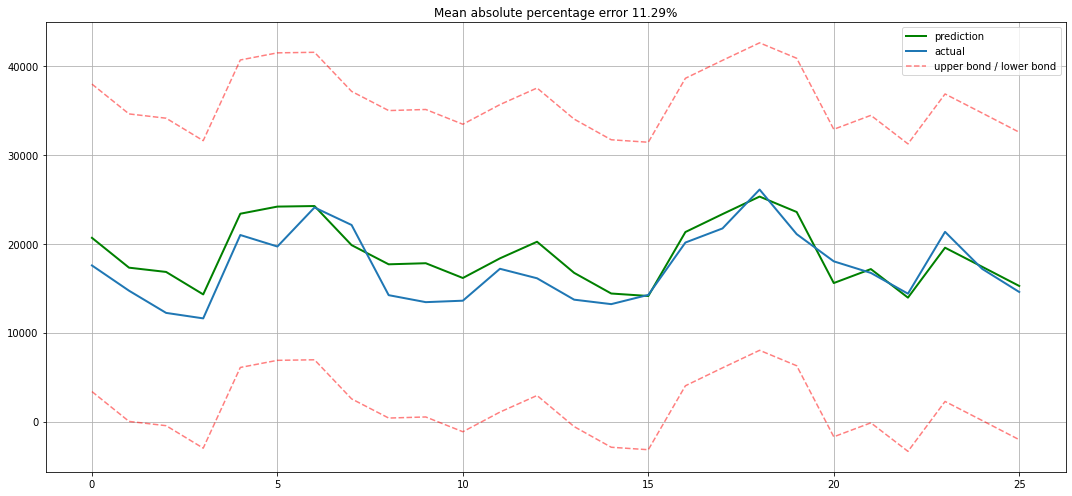

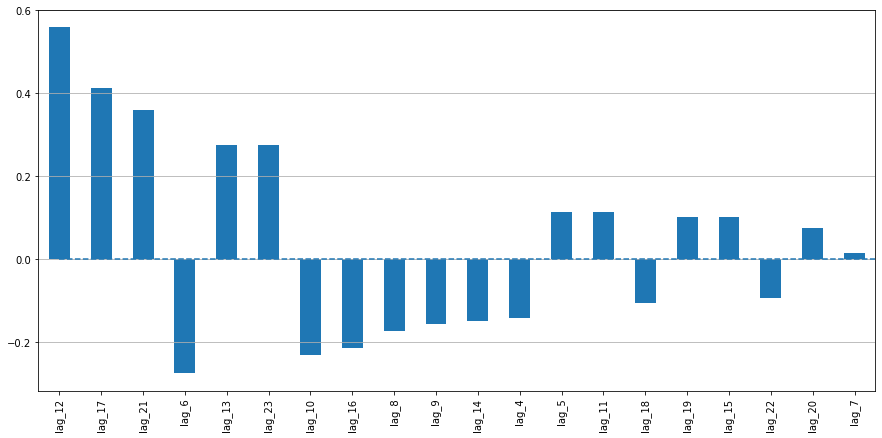

In [25]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Простые лаги и линейная регрессия дали нам прогнозы, которые не так уж далеки от SARIMA с точки зрения качества.  
Мы добавим час, день недели и логическое значение для is_weekend.  
Для этого нам нужно преобразовать текущий индекс фрейма данных в формат datetime и извлечь час и день недели.

In [26]:
data.index = pd.to_datetime(car.Month.values)
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,weekday,is_weekend
1968-08-01,16722,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0,13598.0,13434.0,...,19692.0,20985.0,11608.0,12225.0,14720.0,17562.0,16135.0,13401.0,3,0
1968-09-01,14385,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0,13598.0,...,24081.0,19692.0,20985.0,11608.0,12225.0,14720.0,17562.0,16135.0,6,1
1968-10-01,21342,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0,...,22114.0,24081.0,19692.0,20985.0,11608.0,12225.0,14720.0,17562.0,1,0
1968-11-01,17180,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,...,14220.0,22114.0,24081.0,19692.0,20985.0,11608.0,12225.0,14720.0,4,0
1968-12-01,14577,16722.0,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,...,13434.0,14220.0,22114.0,24081.0,19692.0,20985.0,11608.0,12225.0,6,1


We can visualize the resulting features.

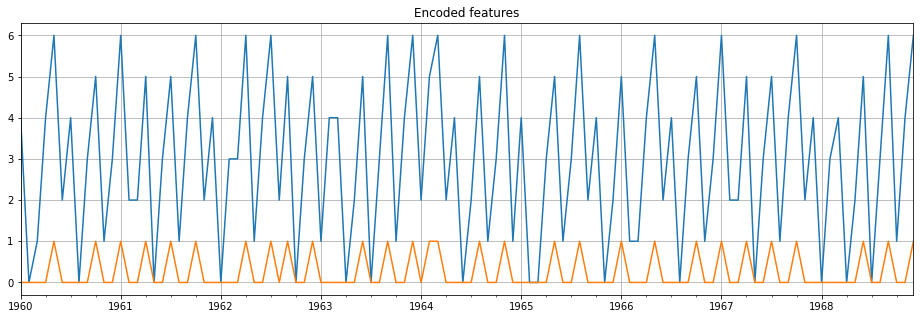

In [27]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

Поскольку теперь у нас есть разные шкалы для наших переменных, нам нужно преобразовать их в одинаковые шкалы для изучения важности функций и, позже, регуляризации.

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

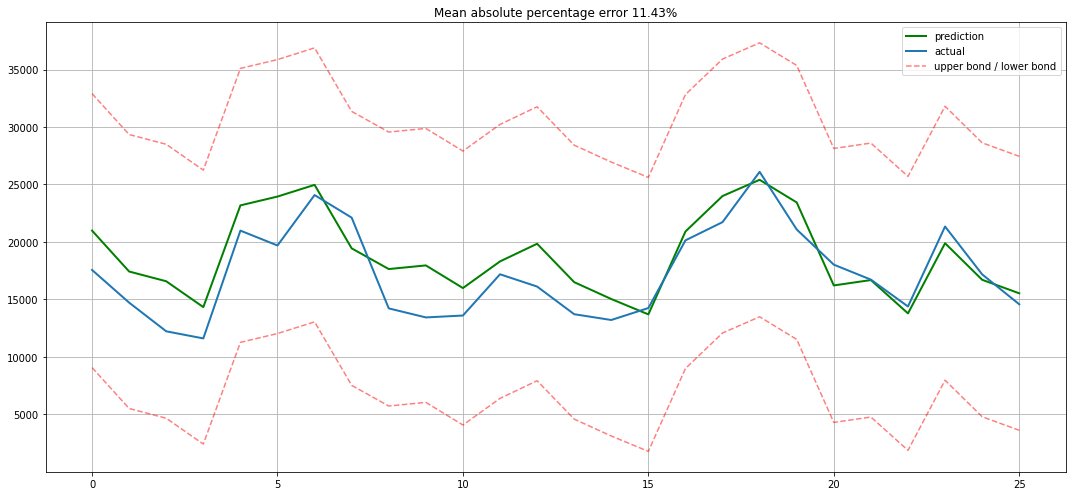

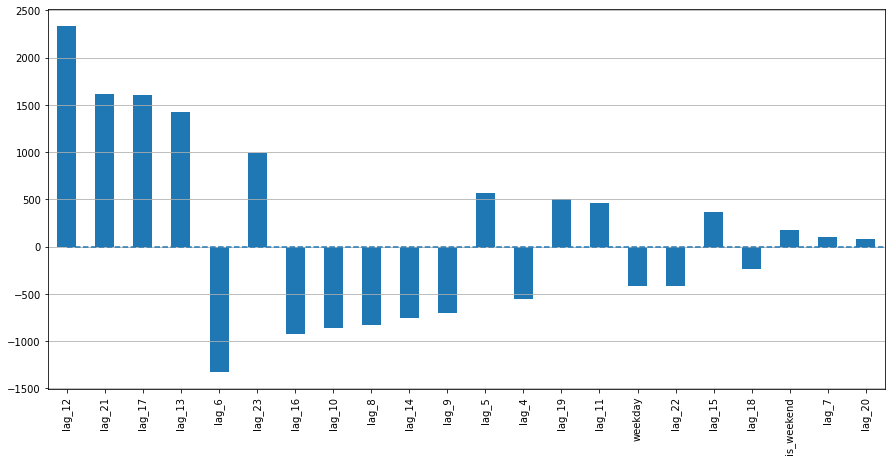

In [29]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Ошибка теста немного увеличилась. Судя по графику коэффициентов, можно сказать, что weekday и is_weekend - нам не помогли. Эту проблему можно решить разными способами; например, мы можем вычислить целевую кодировку не для всего набора поездов, а вместо этого для некоторого окна. Таким образом, кодировки из последнего наблюдаемого окна, скорее всего, лучше описывают текущее состояние серии. В качестве альтернативы мы можем просто отбросить его вручную, так как мы уверены, что в этом случае это только ухудшит ситуацию.

### Target encoding

Кодирование категориальных переменных: кодирование по среднему значению.
Очень важно убедиться, что среднее значение вычисляется только по обучающему набору
(или только по текущей свертке перекрестной проверки), чтобы модель не знала о будущем.

In [30]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

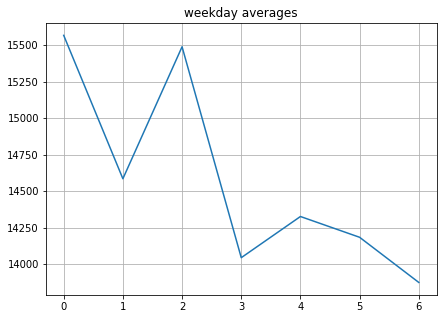

In [31]:
average_hour = code_mean(data, 'weekday', "y")
plt.figure(figsize=(7, 5))
plt.title("weekday averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

In [32]:
def prepareData(df, time, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
   
    # copy of the initial dataset
    data = df.drop(time,1).copy()
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(df[time].values)
#     data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
#         data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(['weekday'], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

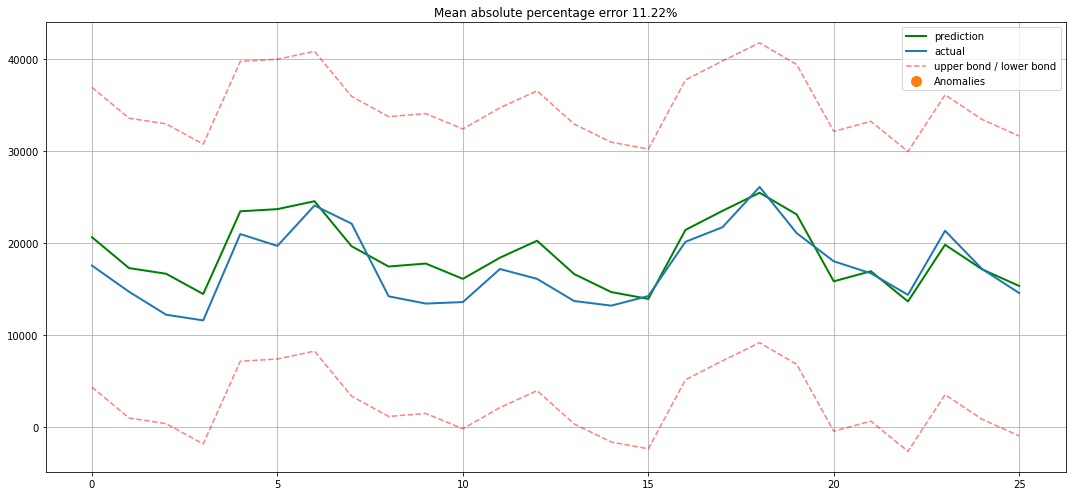

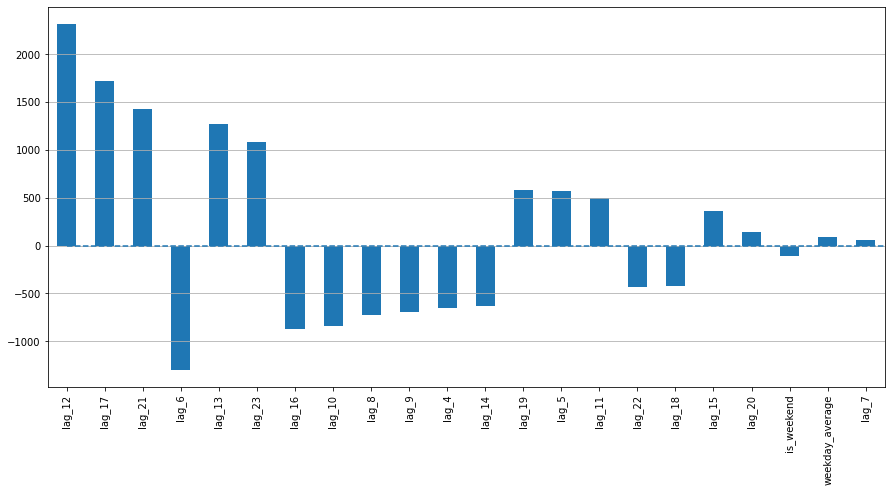

In [33]:
X_train, X_test, y_train, y_test = prepareData(car, time ='Month', lag_start=4, lag_end=24, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

Мы видим некоторое переоснащение! Hour_average был настолько хорош в наборе обучающих данных, что модель решила сосредоточить на нем все свои силы. В результате качество предсказания немного увеличилось. 

### Regularization and feature selection

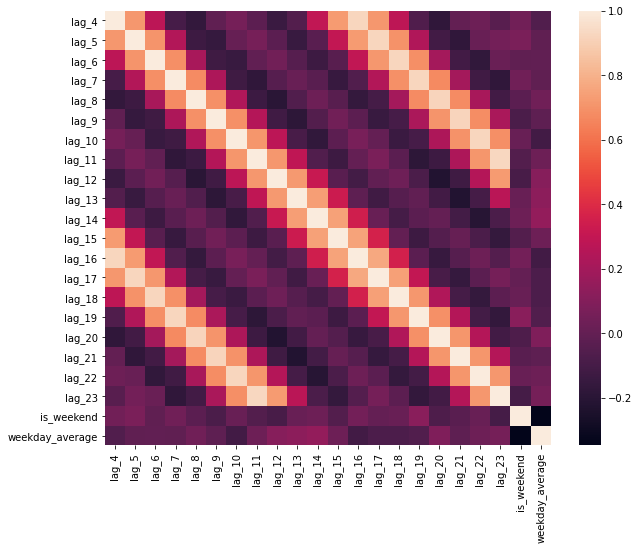

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

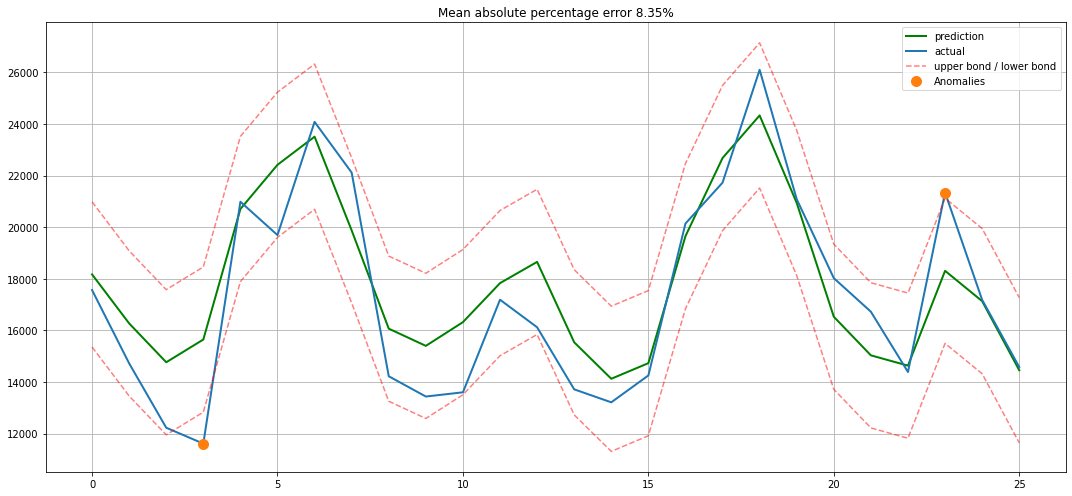

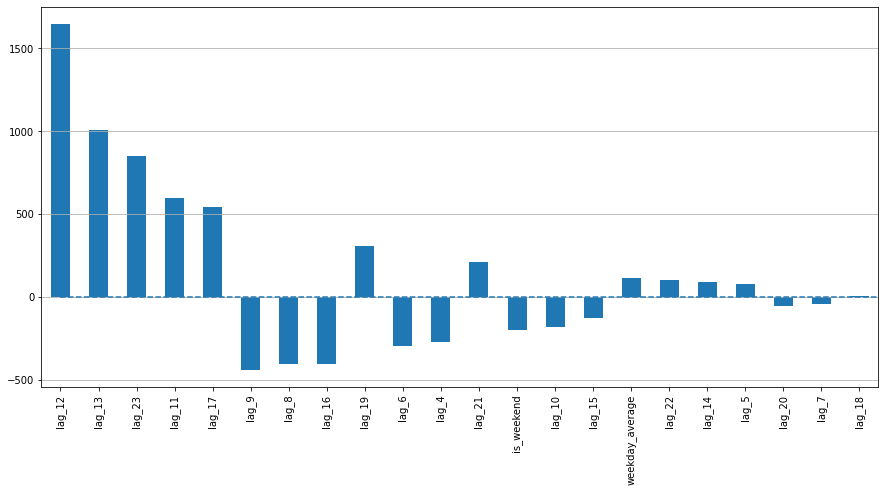

In [35]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

Мы ясно видим, что некоторые коэффициенты становятся все ближе и ближе к нулю (хотя на самом деле они никогда не достигают его), поскольку их важность в модели падает.

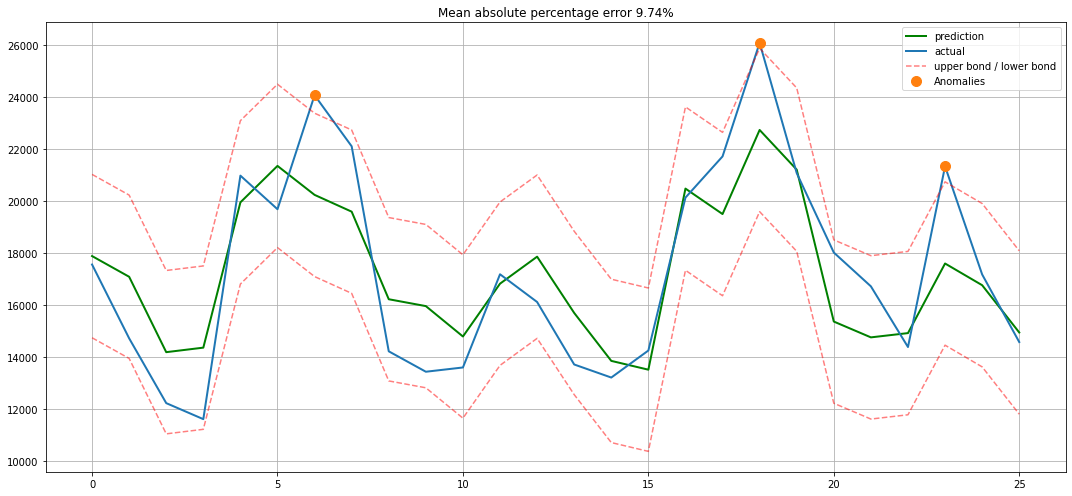

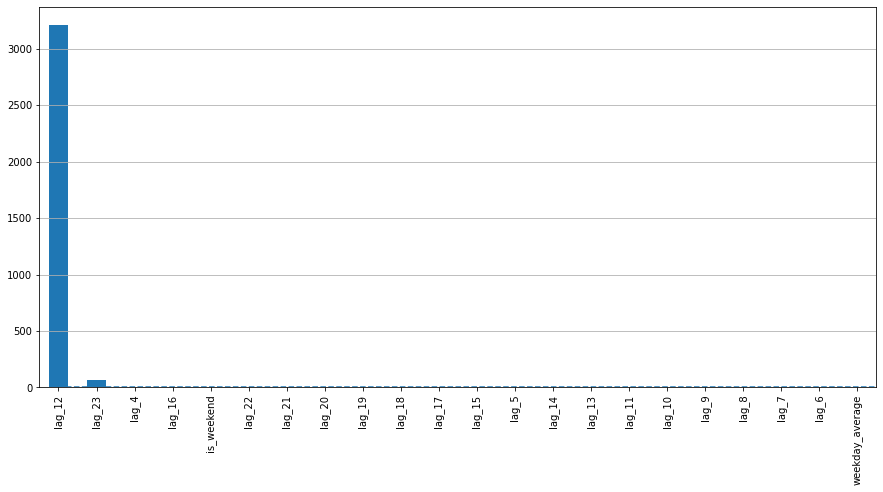

In [36]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Регрессия лассо оказалась более консервативной. Она удалалила почти все признаки и сосредоточилась на одном.